# Traffic Sign Recognition

This project is using the data from the [The German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

    @inproceedings{Stallkamp-IJCNN-2011,
    author = {Johannes Stallkamp and Marc Schlipsing and Jan Salmen and Christian Igel},
    booktitle = {IEEE International Joint Conference on Neural Networks},
    title = {The {G}erman {T}raffic {S}ign {R}ecognition {B}enchmark: A multi-class classification competition},
    year = {2011},
    pages = {1453--1460}}

In [3]:
from readTrafficSigns import *
import cv2
import os
from random import shuffle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.cross_validation import train_test_split
import pandas as pd

import tensorflow as tf
import pickle

C:\Users\Karam\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Karam\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
trainImages, trainLabels = readTrafficSigns('./GTSRB/Training')

In [5]:
print ('trainLabels:',len(trainLabels), 'trainImages:',len(trainImages))

trainLabels: 39209 trainImages: 39209


### Convert labels to one hot array

In [50]:
targets = pd.Series(np.array(trainLabels))
one_hot = pd.get_dummies(targets, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [55]:
print(one_hot_labels.shape)

(39209, 43)


In [58]:
one_hot_labels[1000]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [6]:
trainImages[3000].shape

(31, 32, 3)

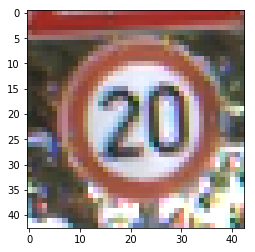

In [7]:
plt.imshow(trainImages[50])
plt.show()

In [25]:
IMG_SIZE = 30 # image_size
LR= 1e-3 #learning rate
MODEL_NAME = 'Traffic_Signs-{}-{}.model'.format(LR,'2conv-basic')

In [62]:
def shuffle_resize_data():
    x_feature = []
    y_feature = []
    data = []
    i = 0
    for img in tqdm(range(len(trainImages))):
        label = one_hot_labels[i]
        gray = cv2.cvtColor(trainImages[img], cv2.COLOR_BGR2GRAY)
        gray_resized = cv2.resize(gray, (IMG_SIZE,IMG_SIZE) ,interpolation = cv2.INTER_CUBIC)
        data.append([np.array(gray_resized), np.array(label)])
        i +=1
    shuffle(data)
    np.save('data.npy',data)
    x_feature , y_feature = zip(*data) 
    return x_feature , y_feature

In [63]:
x_feature , y_feature = shuffle_resize_data()

100%|█████████████████████████████████████████████████████████████████████████| 39209/39209 [00:02<00:00, 14923.50it/s]


In [64]:
#train_data = np.Load('train_data.npy')

In [65]:
print ('trainLabels:',len(y_feature), 'trainImages:',len(x_feature))

trainLabels: 39209 trainImages: 39209


In [66]:
x_feature[100].shape

(30, 30)

In [70]:
y_feature[100].shape

(43,)

### Normalize the data

We need to normalize inputs like this: $$x_{norm} = \frac{x}{255} - 0.5$$

The data frames need to be the form of arrays and normolised. Becuase I'm dealing with grayscale here, I needed to add the dimension at the end of the array else it keras would raise an exception

In [71]:
# normalize the images
#x_train = tf.keras.utils.normalize(x_train)
#x_test = tf.keras.utils.normalize(x_test)

In [72]:
x_train_data = (np.array(x_feature, np.float32) / 255.)
print (x_train_data.shape)
x_train_data = np.expand_dims(x_train_data, axis = 3)
print (x_train_data.shape)

(39209, 30, 30)
(39209, 30, 30, 1)


In [73]:
y_train_data = np.array(y_feature, np.uint8)
print (y_train_data.shape)

(39209, 43)


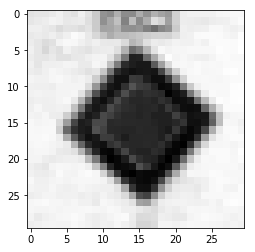

In [74]:
plt.imshow(x_feature[100], cmap=plt.cm.binary)
plt.show()

### Split data to train and test
give 10% for test data from the total data

In [75]:
x_train, x_val, y_train, y_val = train_test_split(x_train_data, y_train_data, test_size=0.1, random_state=2)
print (x_train.shape)
print (x_val.shape)
print (y_train.shape)
print (y_val.shape)

(35288, 30, 30, 1)
(3921, 30, 30, 1)
(35288, 43)
(3921, 43)


# Building the Model

In [76]:
from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Convolution2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten


1. Convetional layer (detect features in image matrix)
2. Pooling layer (recongise features in different angle and/or size)
3. Convetional layer
4. Pooling laye
5. Flattening layer (flatten layers in array of imput)
6. Full connected layer (full connected ANN)
7. Output layer


In [77]:
model = Sequential()

model.add(Convolution2D (filters = 64, kernel_size = (4,4),padding = 'Same', 
                         activation ='relu', input_shape = x_train.shape[1:])) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D (filters = 64, kernel_size = (4,4),padding = 'Same', 
                         activation ='relu')) 
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) 
# fully connected NN 
model.add(Dense(units = 43, activation = 'relu')) 
# output layer
model.add(Dense(units = 43, activation = 'softmax'))

model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])


In [78]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 64)        1088      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 64)        65600     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 43)                134891    
_________________________________________________________________
dense_4 (Dense)              (None, 43)                1892      
Total para

### Fit the model into data

In [79]:
batch_size = 64 
nb_epochs = 10
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=nb_epochs,
                    verbose=2, 
                    validation_data=(x_val, y_val),
                    initial_epoch=0)

Train on 35288 samples, validate on 3921 samples
Epoch 1/10
28s - loss: 1.7893 - acc: 0.5353 - val_loss: 0.5532 - val_acc: 0.8531
Epoch 2/10
17s - loss: 0.3659 - acc: 0.9070 - val_loss: 0.2427 - val_acc: 0.9324
Epoch 3/10
17s - loss: 0.1809 - acc: 0.9549 - val_loss: 0.1688 - val_acc: 0.9630
Epoch 4/10
17s - loss: 0.1111 - acc: 0.9734 - val_loss: 0.1133 - val_acc: 0.9753
Epoch 5/10
17s - loss: 0.0792 - acc: 0.9808 - val_loss: 0.0990 - val_acc: 0.9765
Epoch 6/10
17s - loss: 0.0588 - acc: 0.9862 - val_loss: 0.0775 - val_acc: 0.9814
Epoch 7/10
17s - loss: 0.0473 - acc: 0.9880 - val_loss: 0.0824 - val_acc: 0.9776
Epoch 8/10
17s - loss: 0.0355 - acc: 0.9916 - val_loss: 0.0736 - val_acc: 0.9847
Epoch 9/10
17s - loss: 0.0312 - acc: 0.9928 - val_loss: 0.1106 - val_acc: 0.9732
Epoch 10/10
17s - loss: 0.0281 - acc: 0.9934 - val_loss: 0.0612 - val_acc: 0.9893


In [80]:
#val_loss, val_acc = model.evaluate(x_test,y_test)

In [82]:
model.save('10epoch_10val_NoMean_2conv') # model_1 = tf.keras.models.load_model('10epoch_10val_NoMean_2conv')

In [ ]:
#predictions = new_model.predict([x_test])

In [38]:
def load_test_images(dir_name = './GTSRB/Final_Test/Images'):    
    image_list = []
    files = [os.path.join(dir_name, f) for f in os.listdir(dir_name)]
    for f in files:
        img = cv2.imread(f,0)
        image_list.append(np.array(img))
    return image_list

In [39]:
test_images = load_test_images()

In [42]:
x_test = []
for img in tqdm(range(len(test_images))):
    resized = cv2.resize(img, (IMG_SIZE,IMG_SIZE) ,interpolation = cv2.INTER_CUBIC)
    x_test.append(np.array(resized))

100%|█████████████████████████████████████████████████████████████████████████| 12631/12631 [00:00<00:00, 82193.53it/s]


In [44]:
x_test = np.array(x_test)

In [46]:
x_test.shape

(12631, 30, 30)

In [47]:
x_test = np.expand_dims(x_test, axis = 3)

In [48]:
x_test.shape

(12631, 30, 30, 1)

In [49]:
len(test_images)

12631

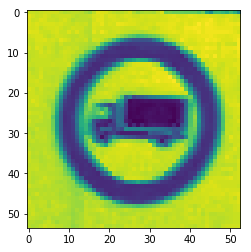

In [50]:
plt.imshow(test_images[0])
plt.show()

In [52]:
model = tf.keras.models.load_model('10epoch_10val_NoMean_2conv')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [55]:
predictions = model.predict([x_test])

In [58]:
predictions.shape

(12631, 43)

In [63]:
import pandas as pd
df =  pd.DataFrame(predictions)

In [64]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,9.509814e-07,6.978897e-02,0.050416,8.909326e-03,6.518856e-02,5.690790e-03,2.145562e-03,4.121341e-04,0.000008,1.167889e-02,...,1.466782e-04,1.133511e-01,6.739925e-05,7.694826e-04,0.000536,8.856104e-02,2.727697e-04,0.034596,2.930505e-03,1.543832e-02
1,1.207491e-13,4.205658e-07,0.017472,1.844568e-04,2.769020e-05,2.615598e-12,2.264055e-09,3.643469e-12,0.003052,5.291403e-10,...,3.098374e-10,9.827867e-05,5.119323e-05,1.763061e-05,0.187079,9.096268e-04,5.076633e-06,0.790435,1.876460e-04,7.230181e-06
2,9.041061e-20,4.282150e-11,0.002575,7.058662e-06,4.002463e-08,1.743462e-18,7.609523e-15,2.173916e-18,0.000837,3.069580e-15,...,1.263353e-14,1.381008e-07,2.550380e-06,2.283242e-08,0.113236,1.736004e-05,8.783495e-09,0.883255,4.940841e-06,1.541733e-08
3,1.243133e-25,5.436948e-15,0.000384,2.891450e-07,2.089139e-10,9.738462e-25,5.267828e-20,1.775937e-24,0.000464,5.173275e-20,...,1.115153e-18,2.359033e-10,3.666694e-07,6.146750e-11,0.108436,3.533069e-07,1.955121e-11,0.890708,1.394794e-07,6.967824e-11
4,1.047911e-31,5.627299e-19,0.000058,1.050858e-08,8.574857e-13,4.067695e-31,2.758277e-25,1.102177e-30,0.000208,5.536299e-25,...,6.160970e-23,3.292178e-13,3.522662e-08,1.303535e-13,0.097765,7.494289e-09,4.146955e-14,0.901969,3.093860e-09,2.435082e-13
